In [2]:
import collections
import datetime
import time
import requests
import yaml

import pandas as pd
import sqlite3 as lite
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

%matplotlib inline

In [2]:
#Hard code cities :(
cityloc = collections.defaultdict()
cityloc = {'Denver':'39.761850,-104.881105',
          'Cleveland':'41.478462,-81.679435',
          'Minneapolis':'44.963324,-93.268320',
          'Washington':'38.904103,-77.017229',
          'Seattle':'47.620499,-122.350876'}

In [12]:
'''
Build MaxTemp Database
'''

#Create SQLite commands
sql=""
for key in cityloc.keys():
    sql = sql + str(key) + " INT, "

#Key of API & url
with open('/Users/danius/galvanize/API/mykeys.yaml', 'r') as f:
    APIkeys = yaml.load(f)
    
APIkey = APIkeys['Forecast_IO']
URLbase = 'https://api.forecast.io/forecast/'

#Create database
con = lite.connect('weather.db')
cur = con.cursor()

with con:
    cur.execute('DROP TABLE IF EXISTS MaxTemp')
    cur.execute("CREATE TABLE MaxTemp (date INT, " + sql[:-2] + ")")
    
    for i in range(30,0,-1):
        evaldate = datetime.datetime.now() - datetime.timedelta(days=i)
        cur.execute('INSERT INTO MaxTemp (date) VALUES (?)', (evaldate.strftime("%Y-%m-%d"),))
        
        for key,val in cityloc.items():
            r = requests.get(URLbase 
                             + APIkey 
                             + '/'
                             + val
                             + ','
                             + str(int(time.mktime(evaldate.timetuple()))))
            
            cur.execute('UPDATE MaxTemp SET ' 
                        + str(key) 
                        + ' = ' 
                        + str(r.json()['daily']['data'][0]['apparentTemperatureMax'])
                        + ' WHERE date = ' 
                        + "'"
                        + evaldate.strftime("%Y-%m-%d")
                        + "';")

Temperature Date Range: 2016-06-23 to 2016-07-22

Max Temperature Details for Seattle:
Max Max Temperature: 76.76
Max Temperature Range: 12.63
Mean Max Temperature: 70.03
Max Temperature Variance: 12.93

Max Temperature Details for Washington:
Max Max Temperature: 103.42
Max Temperature Range: 30.76
Mean Max Temperature: 89.65
Max Temperature Variance: 60.91

Max Temperature Details for Minneapolis:
Max Max Temperature: 104.03
Max Temperature Range: 34.44
Mean Max Temperature: 84.46
Max Temperature Variance: 82.44

Max Temperature Details for Denver:
Max Max Temperature: 91.37
Max Temperature Range: 16.21
Mean Max Temperature: 84.57
Max Temperature Variance: 16.31

Max Temperature Details for Cleveland:
Max Max Temperature: 98.50
Max Temperature Range: 26.46
Mean Max Temperature: 83.24
Max Temperature Variance: 59.33



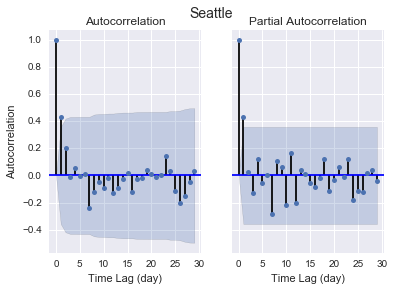

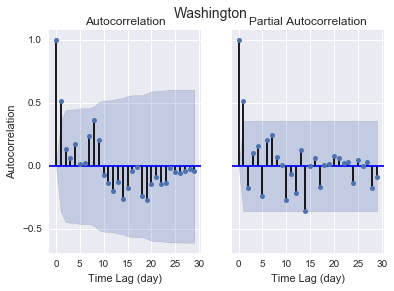

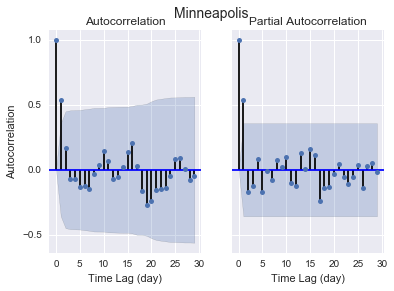

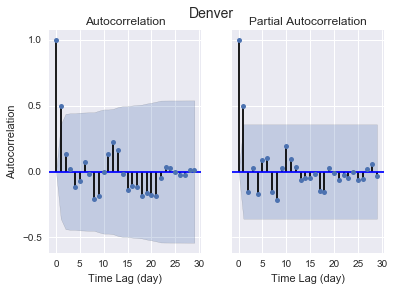

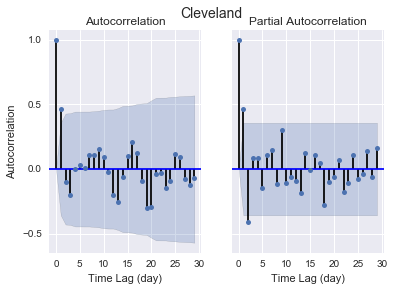

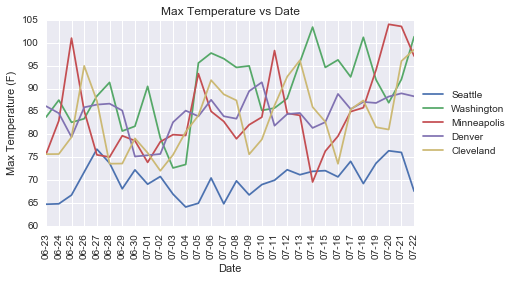

In [35]:
'''
Descriptive statistics on max temperature for each city
'''
con = lite.connect('weather.db')
cur = con.cursor()

#Query database and place into pandas
MTemp=pd.read_sql_query('SELECT * FROM MaxTemp ORDER BY date', con, index_col='date')

print('Temperature Date Range: %s to %s\n' % (min(MTemp.index),max(MTemp.index)))
for key in MTemp.keys():
    print('Max Temperature Details for %s:' % key)
    print('Max Max Temperature: %0.2f' % max(MTemp[key]))
    print('Max Temperature Range: %0.2f' % (max(MTemp[key]) - min(MTemp[key])))
    print('Mean Max Temperature: %0.2f' % MTemp[key].mean())
    print('Max Temperature Variance: %0.2f\n' % MTemp[key].var())
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
    sm.graphics.tsa.plot_acf(MTemp[key].values, ax = ax1)
    ax1.set_xlabel('Time Lag (day)')
    ax1.set_ylabel('Autocorrelation')
    
    sm.graphics.tsa.plot_pacf(MTemp[key].values, ax = ax2)
    ax2.set_xlabel('Time Lag (day)')
    f.suptitle(key, fontsize = 14)
    f.savefig('Autocorrelation - ' + key, dpi = 100)


xlabels = [datetime.datetime.strptime(d, '%Y-%m-%d').strftime('%m-%d') for d in MTemp.index]

plt.figure()
for key in MTemp.keys():
    plt.plot([datetime.datetime.strptime(d,"%Y-%m-%d") for d in MTemp.index], [t for t in MTemp[key]])

lgd = plt.legend([key for key in MTemp.keys()], 
           loc='center left', 
           bbox_to_anchor = (1,0.5))
plt.xticks([datetime.datetime.strptime(d,"%Y-%m-%d") for d in MTemp.index], 
           xlabels, 
           rotation='vertical');
plt.xlabel('Date');
plt.ylabel('Max Temperature (F)');
plt.title('Max Temperature vs Date')
plt.tight_layout()
plt.savefig('Max Temperature vs Day', 
            dpi = 100,
            bbox_extra_artists=(lgd,), 
            bbox_inches='tight')

In [16]:
TempRange = pd.DataFrame(index=[datetime.datetime.strptime(MTemp.index[i],"%Y-%m-%d") 
                                - datetime.datetime.strptime(MTemp.index[0],"%Y-%m-%d") 
                                for i in range(1,len(MTemp.index))],
                         columns = MTemp.columns)

for key, val in MTemp.iteritems():
    TempRange[key] = [val[i] - val[i-1] for i in range(1,len(val))]

print('%s has the largest max temperature delta for a single day with a %0.2f degree change\n' % 
      (max(abs(TempRange)),
       max(abs(TempRange[max(abs(TempRange))]))))

Washington has the largest max temperature delta for a single day with a 22.16 degree change

